# SVM Optimization Problem

Autor: Jan Leyva

All theory behind this document is based on the classes and notes from **Jordi Castro** (UPC-Group on Numerical Optimization and Modelling ).

We goingo to see 3 steps for SVM
1. When classes are linearly separable, maximize the margin between the two classes
2. When classes are not linearly separable, maximize the margin but allow some samples within the margin. That is the soft margin
3. The `Kernel trick` to extend the separation to non linear frontieres

# 1. Linearly separable data

## 1.1. Definition of the problem

We want to classify $m$ points $x_i \in \mathbb{R}^2, i = 1,...,m$

Every point x belongs to one of two classes, linearly separated by the **hyperplane** $w^Tx + \gamma = 0$, such that:
- if x is of class +1 then $w^Tx + \gamma \geq +\delta$
- if x is of class -1 then $w^Tx + \gamma\leq -\delta$

We can normalize assuming $\delta = 1$ -> then every point belongs to +1, -1.

**OBJECTIVE:** Find the hyperplane definite by $(w, \delta) \in \mathbb{R}^{n+1}$ with the maxium distance between parallel planes that we defined before.

- $w$ is the normal to the separation hyperplanes.
- $\delta$ determines its location with respect to the origin

The margin between planes is $\frac{2}{\rVert w \rVert_2}$

#### SVM is a constrained quadratic optimization problem

$$max \frac{2}{\rVert w \rVert_2} $$
$$ Subject \space to:  \space y_i(w^T x_i+ \gamma) \geq 1, \space i = 1,...,m$$

* then, contraints impose:

$$w^Tx + \gamma \geq +1, \space y_i = +1$$
$$w^Tx + \gamma\leq -1, \space y_i = -1 $$

* As we know, we can express it as:
$$ min\frac{1}{2} \rVert w \rVert_2 =  min\frac{1}{2} \rVert w \rVert_2^2$$
$$= min\frac{1}{2} w^Tw $$

* And if we denote by $A \in \mathbb{R}^{mxn}$ the matrix storing rowwise the vectors $x_i$, by $Y = diag(y_1,...,y_m)$ and by e vector of m 1's, the problem is formulated in compact matrix form as:

$$ min \frac{1}{2}w^Tw$$
$$ Subject \space to: \space Y(Aw+\delta e) \geq e$$

## Let's code

In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy import optimize
from sys import exit 



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm, discriminant_analysis, metrics
from sklearn.datasets import make_blobs, make_moons, make_circles

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

from help_functions import ConfMatrix

### Generate the data

In [3]:
def data_generate(n=1000, type_='blobs', split = 0.2 ,random_state=123, std = 1):
    """
    Generate training and test data
    make blobls -> two blobls clusters
    moond       -> two cluster moond clusters
    circles     -> two cicles clusters
    return numpy.array
    """
    
    if type_ == 'blobs':
        X, y = make_blobs(n_samples= n, random_state=random_state, cluster_std = std, centers = 2)
    elif type_ == 'moond':
        X, y = make_moons(n_samples=n, noise=0.1)
    elif type_ == 'circles':
        X, y = make_circles(n_samples=n, noise=0.05)
    
    # change label 0 -> -1
    for i in range(y.shape[0]):
        if y[i] == 0:
            y[i] = -1
    
    # normalize the data
    X = 2*(X-X.min())/(X.max()-X.min()) -1
    
    
    X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size= split, random_state=random_state)
        
    return X_train, X_test, y_train, y_test

### Plot for SVM

In [4]:
def plot_svm(X, y, support_vectors = None, pred = None, q = None, p = None):
    
    # Normalize the data (std)
    X = X/X.std(axis=0)  
    # X = 2*(X-X.min())/(X.max()-X.min()) -1
    
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    # 2 dim plot by feature
    K1 = X[y==-1]
    K2 = X[y==1]
    
    
    plt.scatter(K1[:, 0], K1[:, 1], cmap = pltcolors.ListedColormap(['#2186D2']),
                label = "Group 1", alpha = 0.5)
    plt.scatter(K2[:, 0], K2[:, 1], cmap = pltcolors.ListedColormap(['#F8AE04']),
                label = "Group 2", alpha = 0.5)
    
    
    # plt.scatter(X[:, 0], X[:, 1], cmap = pltcolors.ListedColormap(['#2186D2', '#F8AE04']), alpha = 0.5)
    
    if support_vectors is not None:
        #2*(support_vectors-X.min())/(X.max()-X.min()) -1        
        fig1 = plt.scatter(support_vectors[:,0], support_vectors[:,1], marker = "*",c = "black", label = "Support Vector")
        print("Number of support vectors = %d" % (len(support_vectors)))

    
    if pred is not None:
        bad_class = X[pred != y]
        fig2 = plt.scatter(bad_class[:,0], bad_class[:,1], marker = "x",c = "red", label = "Wrong classified")
        print("Wrong classified = %d" % (len(bad_class)))
        Accuracy = (1-(len(bad_class)/len(X)))*100
        print("Accuracy =", round(Accuracy, 2), "%")

    if q is not None:
        plt.plot(X, (-q - (p[0]*X))/p[1] , 'm', color = 'b')
        plt.plot(X, (-q - (p[0]*X)+1)/p[1] ,'-', color = 'y')
        plt.plot(X, (-q - (p[0]*X)-1)/p[1] , '-', color = 'y')
    
    #if(type(support_vectors) == np.ndarray):
    ax.legend(loc="upper right")
    plt.show()

### Generate separable data

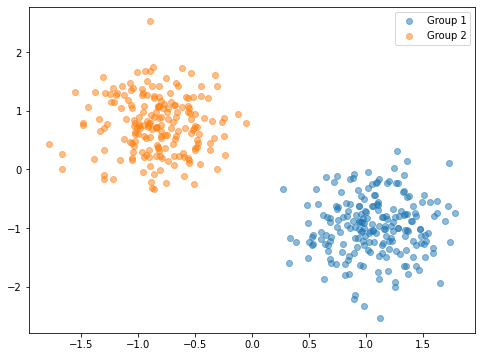

In [5]:
X_train, X_test, y_train, y_test = data_generate(500, std = 1.5)
plot_svm(X_train, y_train)

In [28]:
class SVM():
    "Support Vector Machine with hard margins"
    
    def __init__(self):
        self.params = None
        self.support_vectors = None
        self.std = None
        self.p = None
        self.q = None
    
    def _normalize(self, X, set_value=False):
        if set_value: self.std = X.std(axis=0)        
        return X/self.std

    def get_support_vectors(self):
        return self.support_vectors['X'] * self.std 
    
    def fit(self, X, y_in, c=1):
        
        self._check_y(y_in)
        X = self._normalize(X, set_value=True)
        y = np.copy(y_in)
        
        n_samples, n_features = X.shape   


        xn = X[y == 1].shape[0]
        xm = X[y == -1].shape[0]
        X_1 = X[y == 1]
        X_ = X[y == -1]
    
        a = cp.Variable((n_features,1))
        b = cp.Variable()

        obj = cp.Minimize((cp.norm(a,2)))

        x_constraints = [a.T @ X_1[i] + b >= 1  for i in range(xn)]
        y_constraints = [a.T @ X_[i] + b <= -1 for i in range(xm)]

        constraints = x_constraints +  y_constraints  

        prob = cp.Problem(obj, constraints)
        prob.solve()
        p = a.value
        q = b.value
        
        self.params = {"p": p, "q": q}
        
    def predict(self, X):
        "Reproduce the hyperplane"
        p = self.params['p']
        q = self.params['q']
        return(np.sign(X @ p + q))   
        
    
    def _check_y(self, y):
        classes = np.unique(y)
        assert len(classes)==2,      "y must consist of 2 classes"
        assert abs(classes[0]) == 1, "Class labels must be 1 and -1"
        assert abs(classes[1]) == 1, "Class labels must be 1 and -1"  

## 1.2. Hard margins SVM - linearly separable data

In [29]:
svm = SVM()
svm.fit(X_train, y_train)

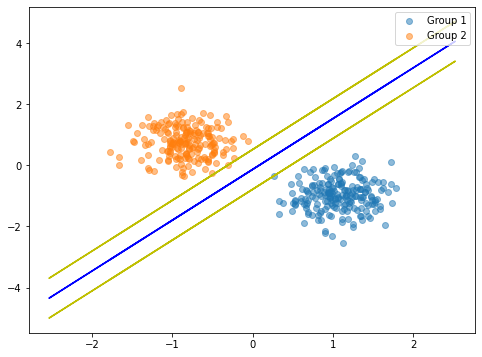

In [8]:
plot_svm(X_train, y_train, q = svm.params['q'], p = svm.params['p'])

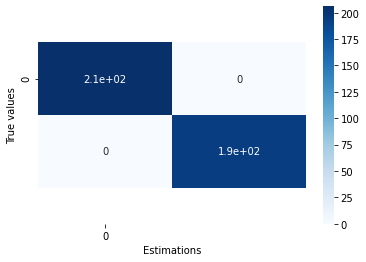

In [10]:
predictt = svm.predict(X_train)
ConfMatrix.plotConfusionMatrix(y_train, predictt, classes = 2)

Wrong classified = 0
Accuracy = 100.0 %


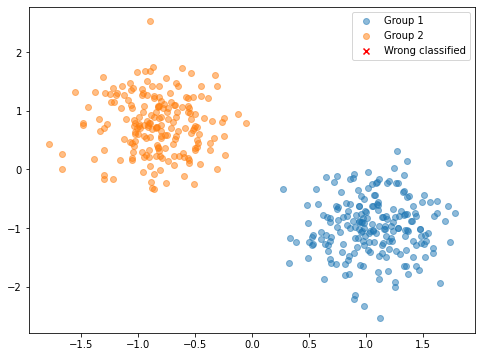

In [11]:
plot_svm(X_train, y_train, pred = predictt[:,0])

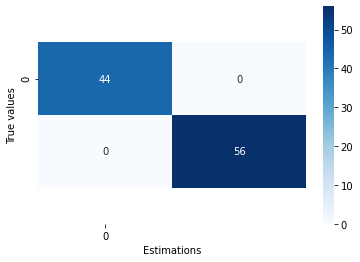

In [12]:
predictt = svm.predict(X_test)
ConfMatrix.plotConfusionMatrix(y_test, predictt, classes = 2)

Wrong classified = 0
Accuracy = 100.0 %


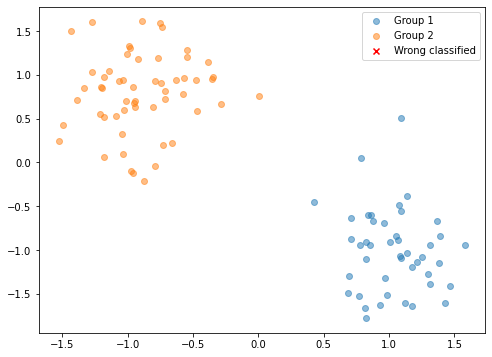

In [13]:
plot_svm(X_test, y_test, pred = predictt[:,0])

## 2. Soft Margin Linear SVM for non separable classes

The example above has little interest as the separation is trivial.

Using the same SVM implementation on a non separable case would not be possible, the solver would fail.

Here comes the soft margin: some $x_i$ are allowed to lie in between the two margin bars.

For solve the problem that not all points can be classify corretly we must add a regularization parameter in max $M$. so, now the problem will be the following:

$$ \min_{w, b} \frac 12 \Vert w \Vert^2 + C \sum_{i=1}^n \xi_i$$
__Subject to $\forall i = 1..n$:__
 $$\xi_i \ge 0$$
 $$y_i(x_i^T w + b) \ge 1 - \xi_i$$
 
### Generate new data

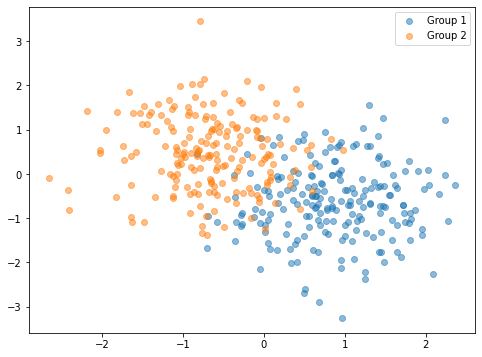

In [14]:
X_train, X_test, y_train, y_test = data_generate(n = 500, type_ = 'blobs', std = 4)
plot_svm(X_train, y_train)

We can reuse the function `svm` but with some modifications

In [30]:
class svm_soft_margin():
    "Support-Vector classification model inseparable data"

    
    def __init__(self):
        self.params = None
        self.support_vectors = None
        self.std = None
        
        
    def _normalize(self, X, set_value=False):
        if set_value: self.std = X.std(axis=0)        
        return X/self.std
    
    def get_support_vectors(self):
        return self.support_vectors['X'] * self.std        
        
    
    def fit(self, X, y_in, c=1):
        
        self._check_y(y_in)
        
        linear = X@X.T
        
        X = self._normalize(X, set_value=True)
        y = np.copy(y_in)
        
        n_samples, n_features = X.shape   

        y = y.reshape([n_samples,1])   

        K = linear  
        P = K* (y@y.T)
        P = cp.Parameter(shape=P.shape, value=P, PSD=True)
        q = np.ones(n_samples)
        A = y.copy().reshape([-1])
        G = np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples)))
        h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * c))
        
        a = cp.Variable(n_samples)
        
        prob = cp.Problem( cp.Minimize((1/2)*cp.quad_form(a, P) - q.T@a),
                 [G@a <= h, A@a == 0.0])
        
        prob.solve()
        
        lagranges  = np.ravel(a.value)
        
        mask = np.abs(lagranges) > 1e-5
        lagranges[np.invert(mask)] = 0
        
        sv_X = X[mask]
        sv_y = y[mask]
        sv_K = sv_X@sv_X.T
        
        lagranges = lagranges.reshape([-1, 1])
        intercept = np.mean(sv_y - sv_K.T@(lagranges[mask] * sv_y))
        weights   = (sv_X.T@(lagranges[mask]*sv_y.reshape([-1,1]))).reshape([-1])
        
        self.params = {'intercept':intercept, 'lagranges' : lagranges[mask], 'weights':weights}
        self.support_vectors = {'X': sv_X, 'y' : sv_y}
        
        
    def predict(self, X):
        
        X = self._normalize(X)
        
        lagranges = self.params['lagranges']
        intercept = self.params['intercept']
        sv_X = self.support_vectors['X']
        sv_y = self.support_vectors['y'].reshape([-1,1])
        
        K = sv_X@X.T
        y = K.T@(lagranges * sv_y) + intercept
        
        return np.sign(y.reshape([-1]))
    
    def _check_y(self, y):
        classes = np.unique(y)
        assert len(classes)==2,      "y must consist of 2 classes"
        assert abs(classes[0]) == 1, "Class labels must be 1 and -1"
        assert abs(classes[1]) == 1, "Class labels must be 1 and -1"

### Fit the model

In [16]:
svm_s_m = svm_soft_margin()
svm_s_m.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


#### Accuracy - train set

Number of support vectors = 118
Wrong classified = 38
Accuracy = 90.5 %


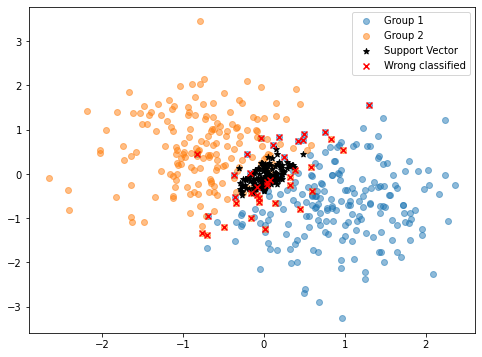

In [18]:
pred_s_m_ = svm_s_m.predict(X_train)
plot_svm(X_train, y_train, pred = pred_s_m_, support_vectors = svm_s_m.get_support_vectors())

### Predictions - test set

Wrong classified = 7
Accuracy = 93.0 %


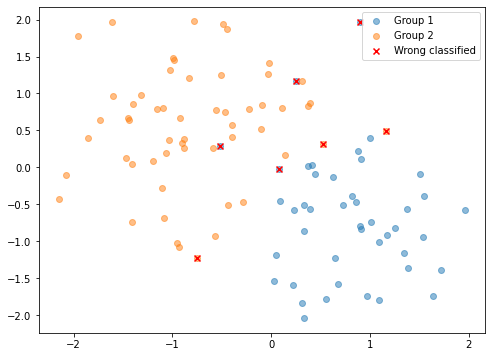

In [19]:
pred_s_m = svm_s_m.predict(X_test)
plot_svm(X_test, y_test, pred = pred_s_m)

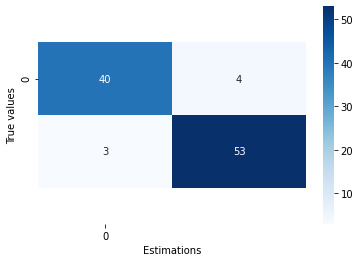

In [20]:
ConfMatrix.plotConfusionMatrix(y_test, pred_s_m, classes = 2)

# 3. Kernel trick for non lineal data

### Generate new non linear data

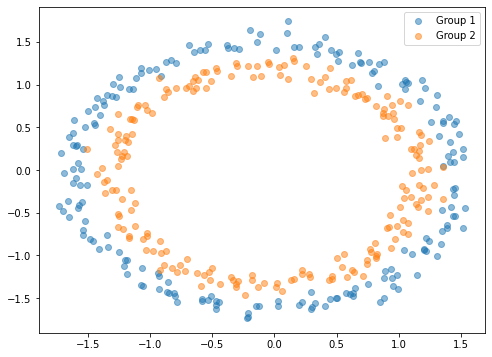

In [21]:
X_train, X_test, y_train, y_test = data_generate(n = 500, type_ = 'circles', std = 2)
plot_svm(X_train, y_train)

In [22]:
class svm_kernel():
    "Support-Vector classification model"

    
    def __init__(self, kernel='linear'):
        self.params = None
        self.support_vectors = None
        self.std = None
        self.kernel_param = None

        if kernel=='linear'    : self.kernel = self._kernel_linear
        if kernel=='poly'      : self.kernel = self._kernel_poly
        if kernel=='rbf'       : self.kernel = self._kernel_rbf
        
        
    def _kernel_linear(self, X1, X2):
        return X1@X2.T
    
    def _kernel_poly(self, X1, X2):
        
        p=self.kernel_param
        if p == None: p = 2.0
        
        return (X1@X2.T + 1.0)**p
    
    def _kernel_rbf(self, X1, X2):
        
        sigma=self.kernel_param
        if sigma == None: sigma = 1/X2.shape[1]
        
        X1  = X1.reshape([X1.shape[0], X1.shape[1], 1])
        X2  = X2.reshape([-1])

        X = np.sqrt(((X1 - X2)**2).sum(axis=1))
        
        return np.exp( -X / (2*sigma**2) )
            
    def _normalize(self, X, set_value=False):
        if set_value: self.std = X.std(axis=0)        
        return X/self.std
    
    def get_support_vectors(self):
        return self.support_vectors['X'] * self.std
    
    
    def fit(self, X, y_in, c=1, kernel_param=None):
        
        self._check_y(y_in)
        self.kernel_param = kernel_param
        
        X = self._normalize(X, set_value=True)
        y = np.copy(y_in)
        
        n_samples, n_features = X.shape   

        y = y.reshape([n_samples,1])   

        K = self.kernel(X, X)   
        P = K* (y@y.T)
        P = cp.Parameter(shape=P.shape, value=P, PSD=True)
        q = np.ones(n_samples)
        A = y.copy().reshape([-1])
        G = np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples)))
        h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * c))
        
        a = cp.Variable(n_samples)
        
        
        prob = cp.Problem( cp.Minimize((1/2)*cp.quad_form(a, P) - q.T@a),
                 [G@a <= h, A@a == 0.0])
        
        prob.solve()
        
        lagranges  = np.ravel(a.value)
        
        mask = np.abs(lagranges) > 1e-5
        lagranges[np.invert(mask)] = 0
        
        sv_X = X[mask]
        sv_y = y[mask]
        sv_K = self.kernel(sv_X, sv_X)
        
        lagranges = lagranges.reshape([-1, 1])
        intercept = np.mean(sv_y - sv_K.T@(lagranges[mask] * sv_y))
        weights   = (sv_X.T@(lagranges[mask]*sv_y.reshape([-1,1]))).reshape([-1])
        
        self.params = {'intercept':intercept, 'lagranges' : lagranges[mask], 'weights':weights}
        self.support_vectors = {'X': sv_X, 'y' : sv_y}
        
        
    def predict(self, X):
        
        X = self._normalize(X)
        
        lagranges = self.params['lagranges']
        intercept = self.params['intercept']
        sv_X = self.support_vectors['X']
        sv_y = self.support_vectors['y'].reshape([-1,1])
        
        K = self.kernel(sv_X, X)
        y = K.T@(lagranges * sv_y) + intercept
        
        return np.sign(y.reshape([-1]))
    
    def _check_y(self, y):
        classes = np.unique(y)
        assert len(classes)==2,      "y must consist of 2 classes"
        assert abs(classes[0]) == 1, "Class labels must be 1 and -1"
        assert abs(classes[1]) == 1, "Class labels must be 1 and -1"

### Fit the model with 'poly' Kernel

In [23]:
svm_k = svm_kernel(kernel = 'poly')
svm_k.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


#### Accuracy - train set

Wrong classified = 7
Accuracy = 98.25 %


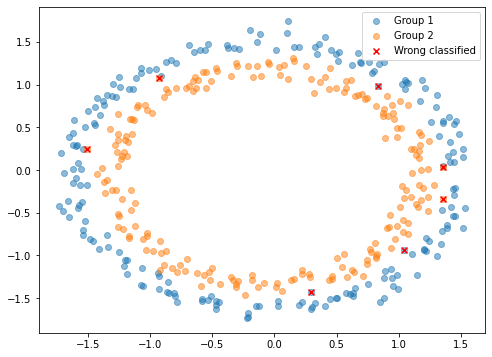

In [25]:
pred_s_k_ = svm_k.predict(X_train)
plot_svm(X_train, y_train, pred = pred_s_k_, )

### Predictions - test set

Wrong classified = 3
Accuracy = 97.0 %


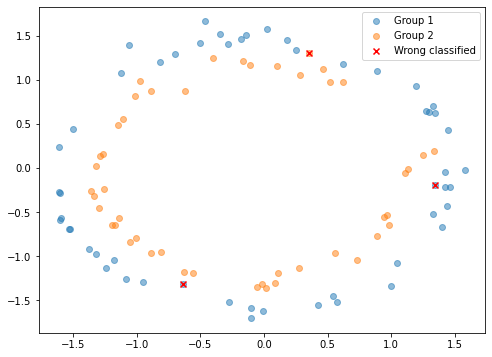

In [26]:
pred_s_k = svm_k.predict(X_test)
plot_svm(X_test, y_test, pred = pred_s_k)

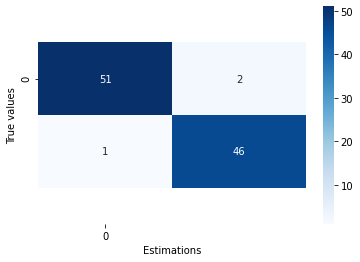

In [27]:
ConfMatrix.plotConfusionMatrix(y_test, pred_s_k, classes = 2)

Check out my [Github](https://github.com/JanLeyva) Jan Leyva.